# Population genetics: deterministic and stochastic discrete-time models

## [Models in Population Biology](http://modelspopbiol.yoavram.com)
## Yoav Ram

In [2]:
import random

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import sympy
sympy.init_printing()
import seaborn as sns
sns.set_context('talk')

Today we focus on **discrete-time models**.
These models can follow, for example:

- The size of an insect population in year i;
- The proportion of individuals in a population carrying a particular gene in the i-th generation;
- The number of cells in a bacterial culture on day i;
- The concentration of a toxic gas in the lung after the i-th breath;
- The concentration of drug in the blood after the i-th dose.

We will model a population with two distinct **types**, focusing on the change in the frequency of individuals in each of these types from one time point to the next.
These types can model [colored balls](https://en.wikipedia.org/wiki/Polya_urn_model), genes, product, health vs. disease, or even technologies such as USB plug types.

We will start with a simple deterministic one-dimensional model, then develop a stochastic model that adds random sampling.

# Discrete-time univariate deterministic model: Haploid selection

We will consider a *vary large* population with two types, $A$ and $B$.
We'll think about these types as two genetic variants $A$ and $B$, for example, two types of bacteria, one that likes to eat white sugar and one that prefers brown sugar.
Or we could think about ancient humans that can either be hunters or gatherers (assuming that this traits goes from father to son or from mother to daughter).

The assumption of a very large population means that we can use the *law of large numbers* to assume that noise or randomness have very little effect on the dynamics, hence we use a *deterministic* model.
The distinction will become clearer below when we consider a *stochastic* model.

An important concept in this model is **fitness**:

> Fitness is the reproductive success, composed of survival, mating success, fecundity etc. When a trait that affects fitness is heritable -- the offspring have the same trait as the parent -- then it will tend to increase in frequency.

We denote the fitness of $A$ relative to $B$ as $1+s$, hence $s$ is the relative advantage of $A$, or $A$'s **selection coefficient**.
This essentially means that *on average*, $A$ leaves $1+s$ more offspring compared to $B$.

We denote the frequency of $A$ and $B$ as $p$ and $1-p$ and write an equation that describes the frequency of $A$ in the next generation, $p'$:

$$
p' = \frac{p (1+s)}{p (1+s) + 1-p} \quad (1)
$$

where $p (1+s) + 1-p$ is the **mean fitness** of the population, usually denoted $\bar w$.

This model is attributed to [Haldane 1924](link.springer.com/article/10.1007%2FBF02459574).

![Haldane](https://www.biografiasyvidas.com/biografia/h/fotos/haldane.jpg)

**[J.B.S. Haldane](https://en.wikipedia.org/wiki/J._B._S._Haldane), 1892-1964**

Let's write a function that iterates eq. 1 a specific number of generations.

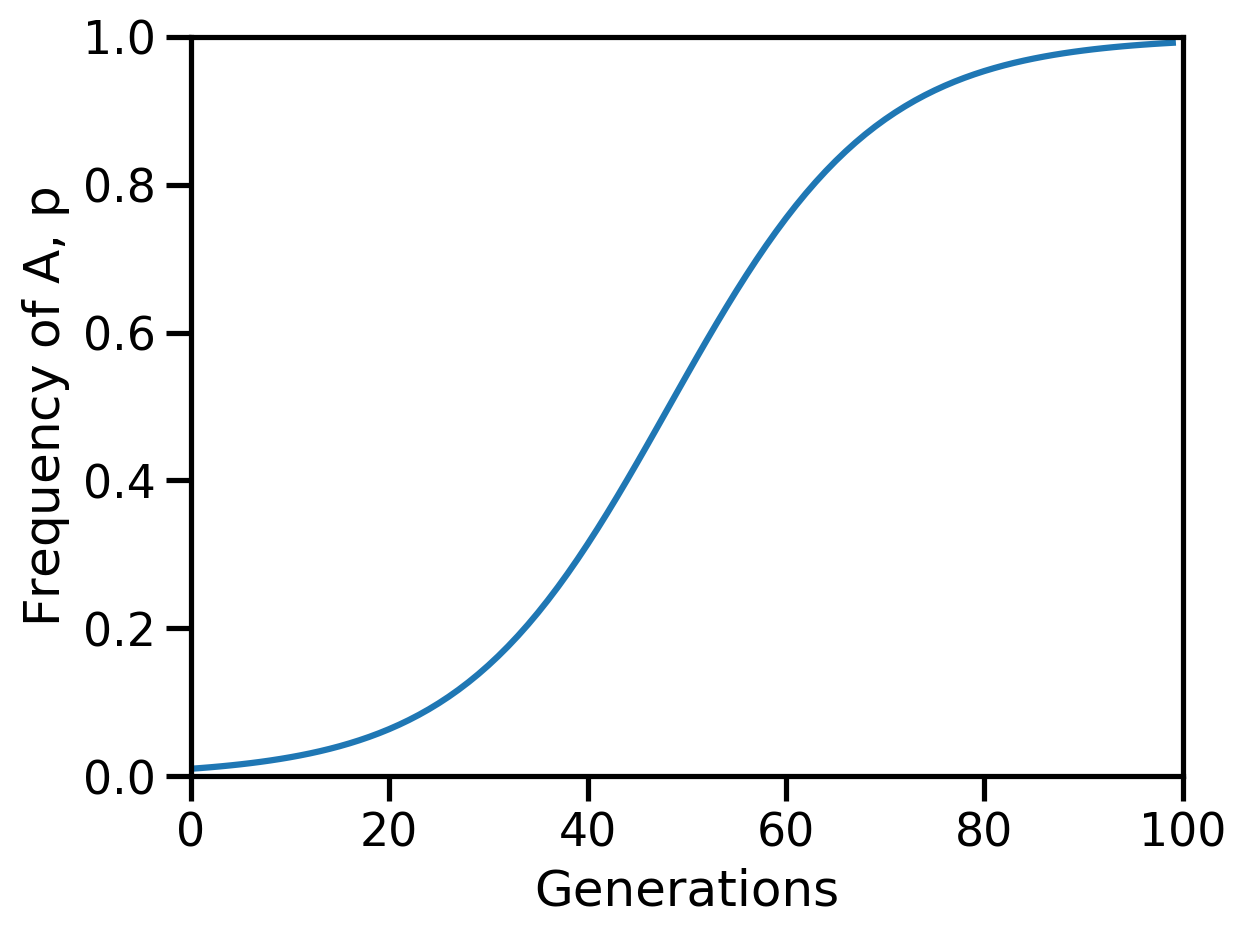

In [5]:
def haploid_selection(p0, s, tmax):
    p = [p0]

    for t in range(1, tmax):
        p.append( p[t-1] * (1 + s) / (1 + p[t-1] * s) )

    return p

p = haploid_selection(0.01, 0.1, 100)
plt.plot(p)
plt.xlabel('Generations')
plt.ylabel('Frequency of $A$, $p$')
plt.ylim(0, 1)
plt.xlim(0, len(p));

Let's see how fast evolution is for different strengths of selection $s$, i.e., advantages to $A$ over $B$.

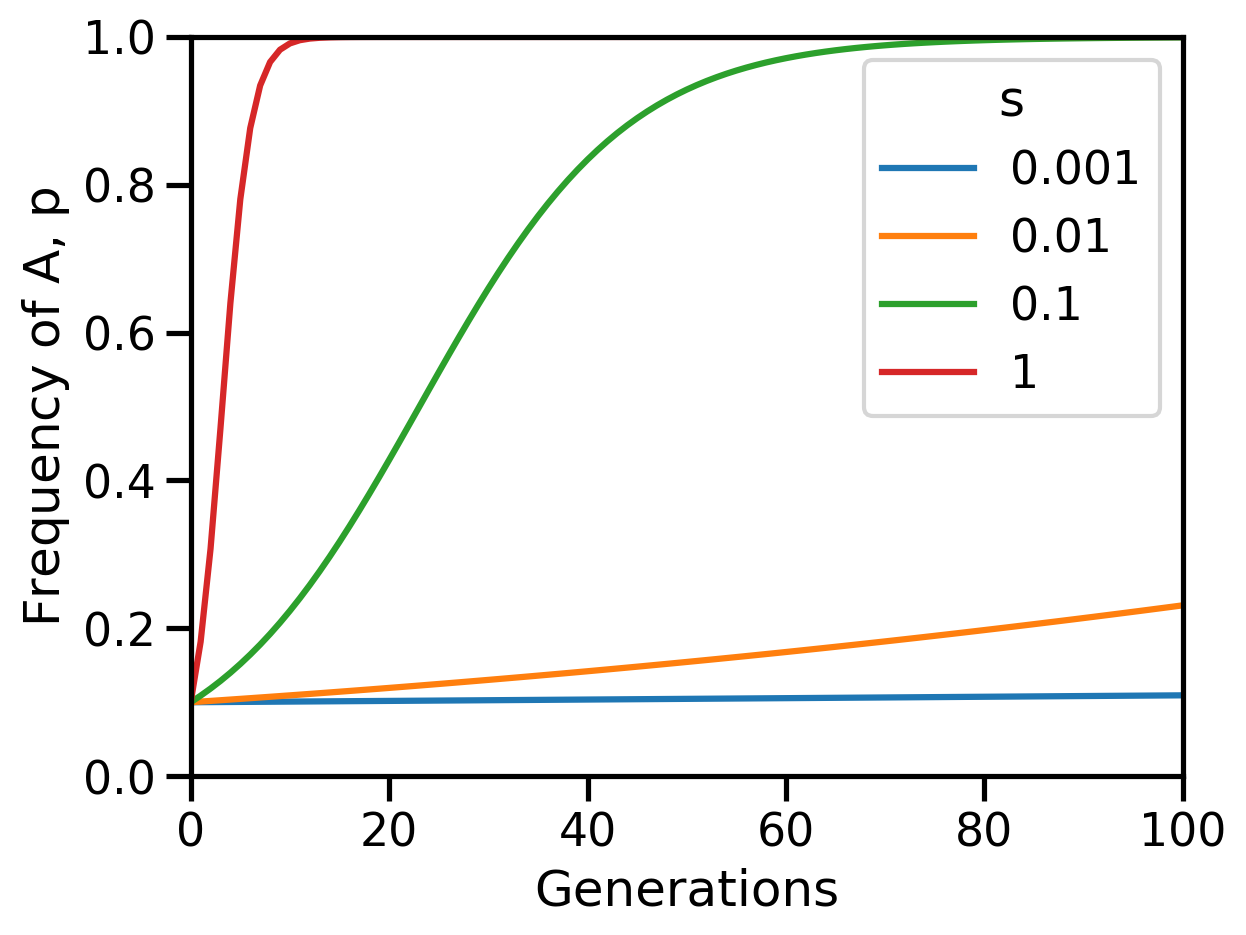

In [6]:
for s in (0.001, 0.01, 0.1, 1):
    plt.plot(haploid_selection(0.1, s, 100000), label=s)

plt.xlabel('Generations')
plt.ylabel('Frequency of $A$, $p$')
plt.ylim(0, 1)
plt.xlim(0, len(p))
plt.legend(title='s');

So the strength of selection has a hugh effect on the speed of evolution.

## Recurrence solution

The recurrence equation (1) can be solved so that we have an equation of $p(t)$ as a function of time (generations).

Let's write the recurrence for $q_t=(1-p_t)$ the frequency of $B$ (it's a bit easier to solve that way):

$$
q_t = \frac{q_{t-1}}{q_t + (1-q_t)(1+s)} = 
\frac{q_{t-1}}{1-s(1-q_t)}
$$

If we write the formula for $q_1$ and $q_2$ we can get

$$
q_2 = \frac{q_0}{q_0 + (1-q_0)(1+s)^2}
$$

which hints at 

$$
q_t = \frac{q_0}{q_0 + (1-q_0)(1+s)^t}
$$

and quivalently

$$
p_t = 1 - \frac{1-p_0}{1-p_0 + p_0(1+s)^t}
$$


Let's check it numerically:

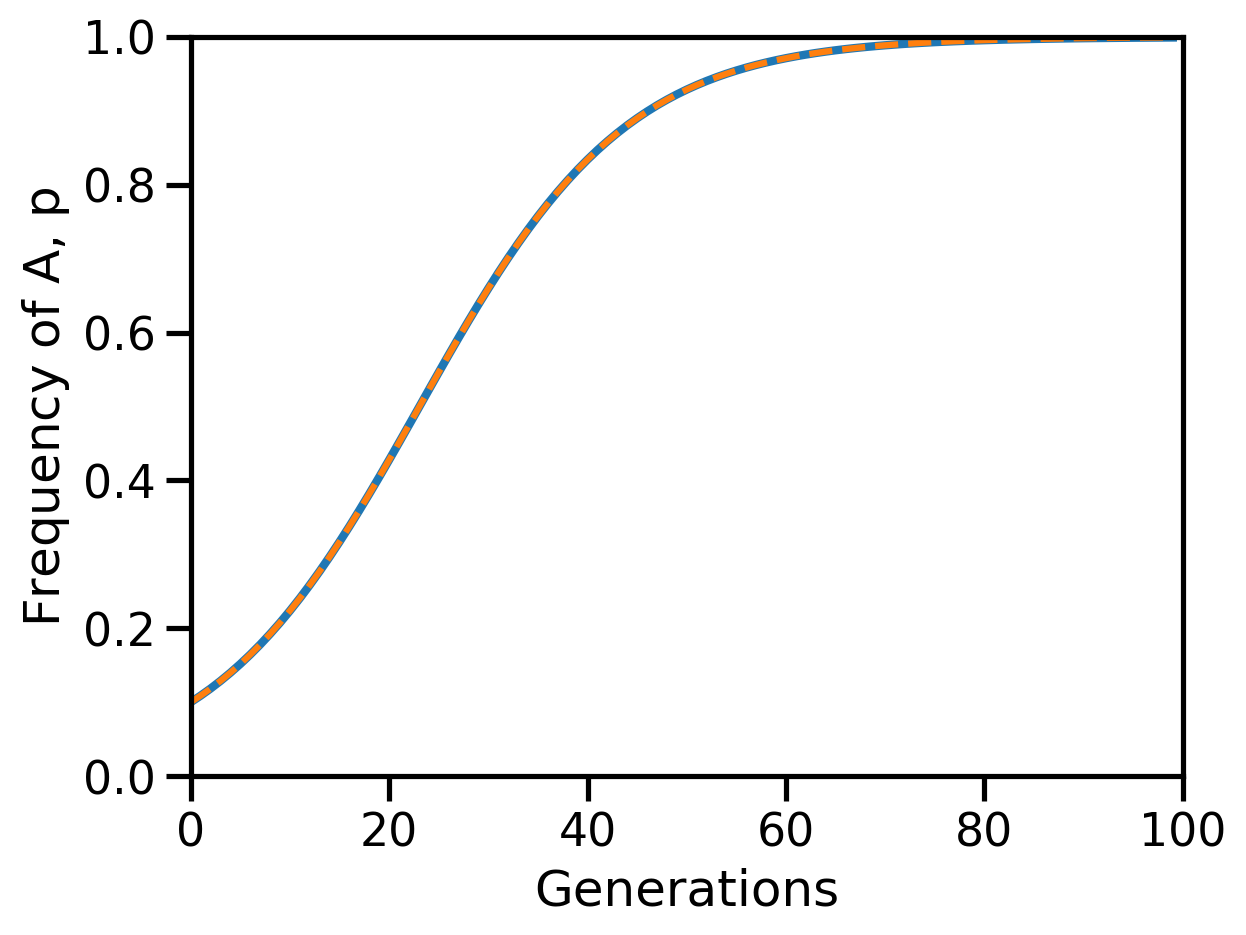

In [7]:
def haploid_selection_solution(p0, s, tmax):
    return [
        1 - (1-p0)/(1 - p0 + p0 * (1 + s)**t)
        for t in range(int(tmax))
    ]

plt.plot(haploid_selection(0.1, 0.1, 100), lw=3, label='recurrence')
plt.plot(haploid_selection_solution(0.1, 0.1, 100), '--', label='solution')
plt.xlabel('Generations')
plt.ylabel('Frequency of $A$, $p$')
plt.ylim(0, 1)
plt.xlim(0, len(p));

Looks good, so we can try and prove it using induction:

$$
q_{t+1} = \frac{q_t}{1+s(1-q_t)} = \\
\frac{\frac{q_0}{q_0 + (1-q_0)(1+s)^t}}{1+s\Big(1-\frac{q_0}{q_0 + (1-q_0)(1+s)^t}\Big)} = \\
\frac{\frac{q_0}{q_0 + (1-q_0)(1+s)^t}}{1+s-\frac{sq_0}{q_0 + (1-q_0)(1+s)^t}} = \\
\frac{q_0}{(1+s)(q_0 + (1-q_0)(1+s)^t) - sq_0} = \\
\frac{q_0}{q_0+s q_0 + (1-q_0)(1+s)(1+s)^{t}) - sq_0} = \\
\frac{q_0}{q_0 + (1-q_0)(1+s)^{t+1})}
$$

which proves the induction.

## Fixation time (deterministic model)

Using the closed form solution of eq. 1, we can find the time for increase from some low frequency $p_0$ to a high frequency $1-p_0$, which will approximate the time it takes type $A$ to dominate the population when it is initially rare -- this is called the **fixation time**.

We need to solve the following for $t$:

$$
1-p_0 = 1-\frac{1-p_0}{1-p_0+p_0(1+s)^t} \Rightarrow \\
p_0 = \frac{1-p_0}{1-p_0+p_0(1+s)^t} \Rightarrow \\
(1+s)^t = \frac{(1-p_0)^2}{p_0^2}
$$

Taking the log of both sides

$$
t  = \frac{2\log{(1-p_0)/p_0} }{log (1+s)}
$$

If we assume that $p_0\sim 0$ so $(1-p_0)/p_0 \sim p_0^{-1}$ then

$$
t  = \frac{-2\log{p_0}}{log (1+s)}
$$

Let's validate using the numericall iteration.

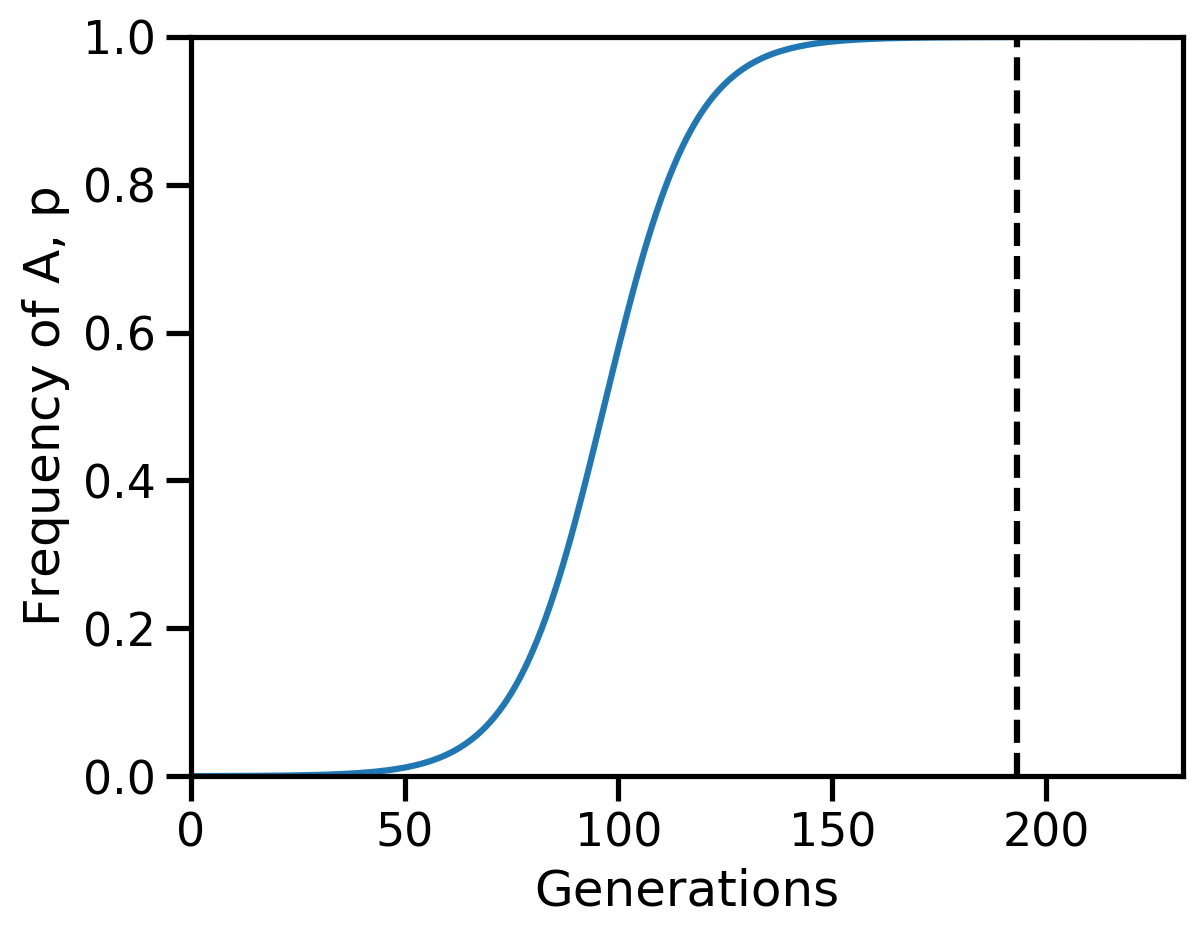

In [8]:
p0 = 1e-4
s = 0.1
t = -2 * np.log(p0) / np.log(1+s)

plt.plot(haploid_selection_solution(p0, s, 1.2*t), '-')
plt.axvline(t, ls='--', color='k')
plt.xlabel('Generations')
plt.ylabel('Frequency of $A$, $p$')
plt.ylim(0, 1)
plt.xlim(0, 1.2*t);

Of course, the assumption of a *very large population* breaks when either the population size is not very large, or when the population is very large but one of the type is extermely rare.
We'll come back to this later.

# Discrete-time univariate deterministic model: Diploid selection

Let's set up a diploid version of the same model we had above:
- Alleles: $A_1$, $A_2$
- Allele frequencies: $p$, $q=1-p$
- Genotypes: $A_1 A_1$, $A_1 A_2$, $A_2 A_2$
- Genotype frequencies: $p^2$, $2pq$, $q^2$
- Fitness: $w_{11}=1$, $w_{12}=1-hs$, $w_{22}=1-s$
with $s>0$. 
The latter are parameterizations of the fitness values, such that $s$ is the selection agains $A_2$ and $h$ is the dominance of $A_1$ over $A_2$.

So, allele frequencies after viability selection are
$$
p' = \frac{p^2 + p q (1-hs)}{\bar{w}} \\
q' = \frac{q^2 (1-s) + p q (1-hs)}{\bar{w}} \\
\bar{w} = p^2 + 2 p q (1-hs) + q^2 (1-s)
$$

In [12]:
def diploid_selection(p0, s, h, tmax):
    p = [p0]

    for t in range(1, tmax):
        p_ = p[t-1]
        q_ = 1-p_
        wbar  = p_*p_ + 2*p_*q_*(1 - h*s) + q_*q_*(1-s) # mean fitness
        p.append( 
            (p_*p_ + p_*q_*(1-h*s)) / wbar
        )

    return p

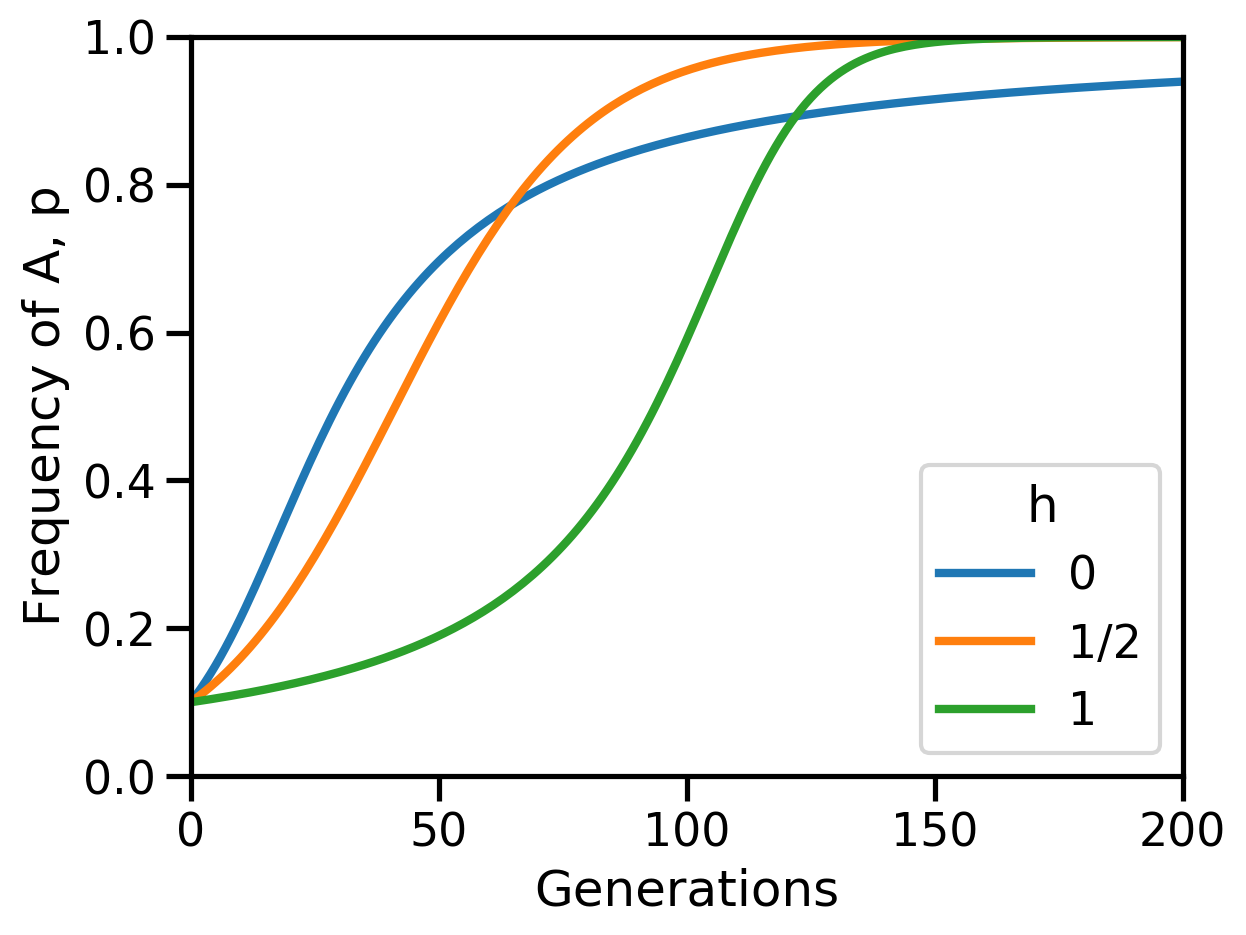

In [24]:
plt.plot(diploid_selection(0.1, 0.1, 0, 200), lw=3, label='0')
plt.plot(diploid_selection(0.1, 0.1, 0.5, 200), lw=3, label='1/2')
plt.plot(diploid_selection(0.1, 0.1, 1, 200), lw=3, label=1)
plt.xlabel('Generations')
plt.ylabel('Frequency of $A$, $p$')
plt.legend(title='$h$')
plt.ylim(0, 1)
plt.xlim(0, 200);

## Equilibria

First, we will examine the equilibria, or fixed points, of this system.

**Definition.**
$p*$ is an *equilibrium* if it satisfies the equation $p'=p$.

### Fixation equilibria
Some of the equilibria are easy to find.
Setting $p=0$ in $p'$,
$$
0 = \frac{0}{w_3} = 0
$$

and setting $q=0 \; (p=1)$ in $q'$
$$
0 = \frac{0}{w_1} = 0
$$

**Result.**
Fixation of $A_2$ ($p=0$) and $A_1$ ($p=1$) are both equilibria.

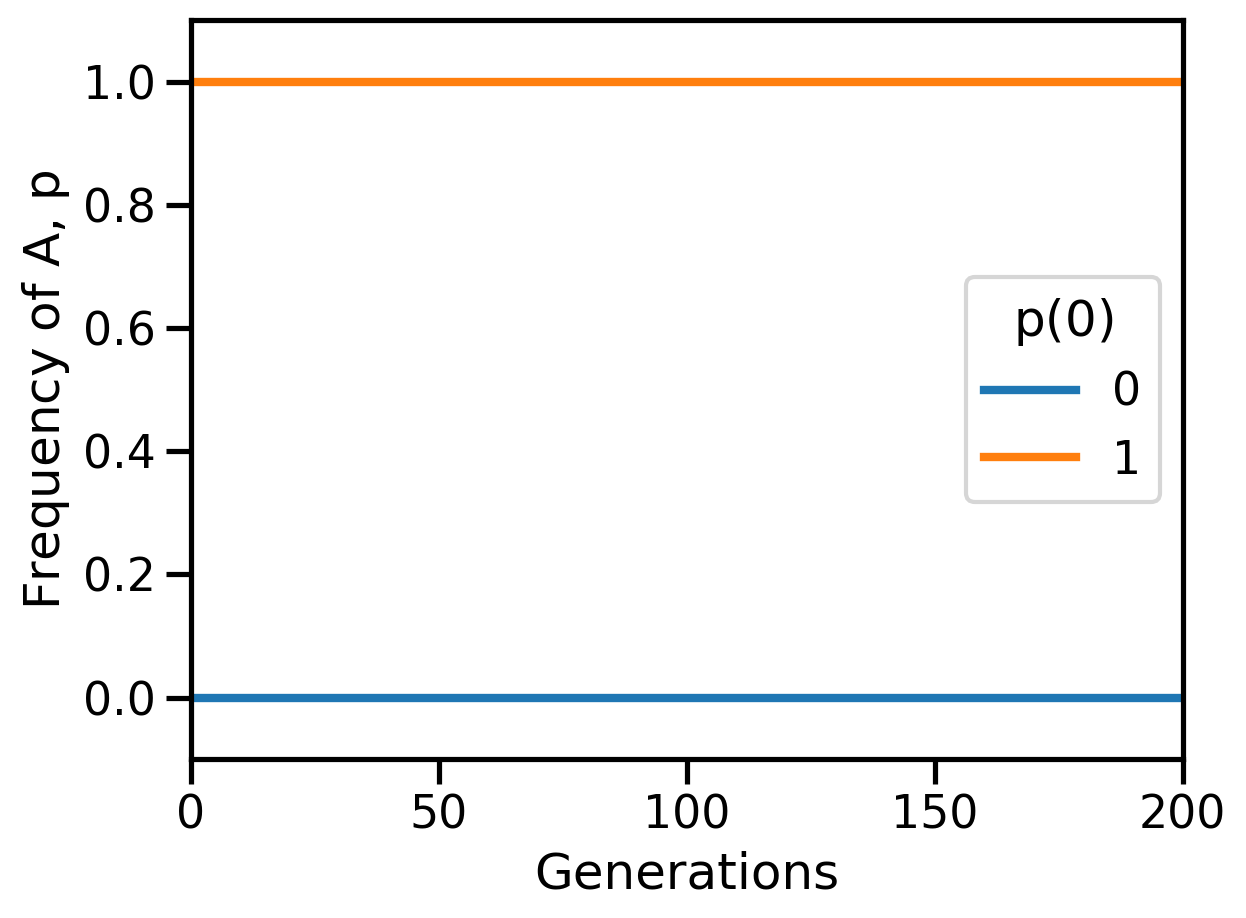

In [27]:
plt.plot(diploid_selection(0, 0.1, 0.5, 200), lw=3, label='0')
plt.plot(diploid_selection(1, 0.1, 0.5, 200), lw=3, label='1')
plt.xlabel('Generations')
plt.ylabel('Frequency of $A$, $p$')
plt.legend(title='$p(0)$')
plt.ylim(-0.1, 1.1)
plt.xlim(0, 200);

### Polymorphic equilibria

**Definition.** *Polymorphism* is the the occurrence of more than one type or form in the same population of a species: $0 < p < 1$.

Do we have a polymorphic equilibrium?
Let's solve for a general $p^*$.
First, we assume $p \ne 0$ (because that is not a polymorphic equilibrium) we can divide by $p$,
$$
p = \frac{p^2 w_1 + p q w_2}{p^2 w_1 + 2 p q w_2 + q^2 w_3} \Rightarrow \\
1 = \frac{p w_1 + q w_2}{p^2 w_1 + 2 p q w_2 + q^2 w_3} \\
p^2 w_1 + 2 p q w_2 + q^2 w_3 = p w_1 + q w_2 \Rightarrow \\
p^2 w_1 - p w_1 + 2 p q w_2 - q w_2 + q^2 w_3 = 0 \Rightarrow \\
-p(1-p) w_1 -(1-p)(1-2p) w_2 + (1-p)^2 w_3 = 0
$$

Second, we assume $p \ne 1$ (again that is not a polymorphic equilibrium), so we can divide by $1-p$:
$$
-p(1-p) w_1 -(1-p)(1-2p) w_2 + (1-p)^2 w_3 = 0 \Rightarrow \\
-p w_1 -(1-2p) w_2 + (1-p) w_3 = 0 \Rightarrow \\
-p w_1 -(1-2p) w_2 + (1-p) w_3 = 0 \Rightarrow \\
p (-w_1 +2 w_2 - w_3) - w_2 + w_3 = 0
$$

So we have
$$
p (-w_1 +2 w_2 - w_3) - w_2 + w_3 = 0 \Rightarrow \\
p (-1 +2 (1-hs) - 1 + s) - 1 + s + 1 - hs = 0 \Rightarrow \\
p s(1-2h) + s(1-h) = 0 \Rightarrow \\
p^* = \frac{h-1}{2h-1}
$$
So we have the following result≥

**Result.**
If a polymorphic equilibrium exists, it is $p^* = \frac{h-1}{2h-1}$.

Note that $p^*$ is a frequency so it must satisfy
$0 < \frac{h-1}{2h-1} < 1$.

Now, $s>0$ and if we check for $h$ we find that this occurs only if $h<0$ or $h>1$.

**Result.**
When $h < 0$ or $1 < h$, a polymorphic equilibrium exists.
When $0 \le h \le 1$, a polymorphic equilibrium cannot exist.

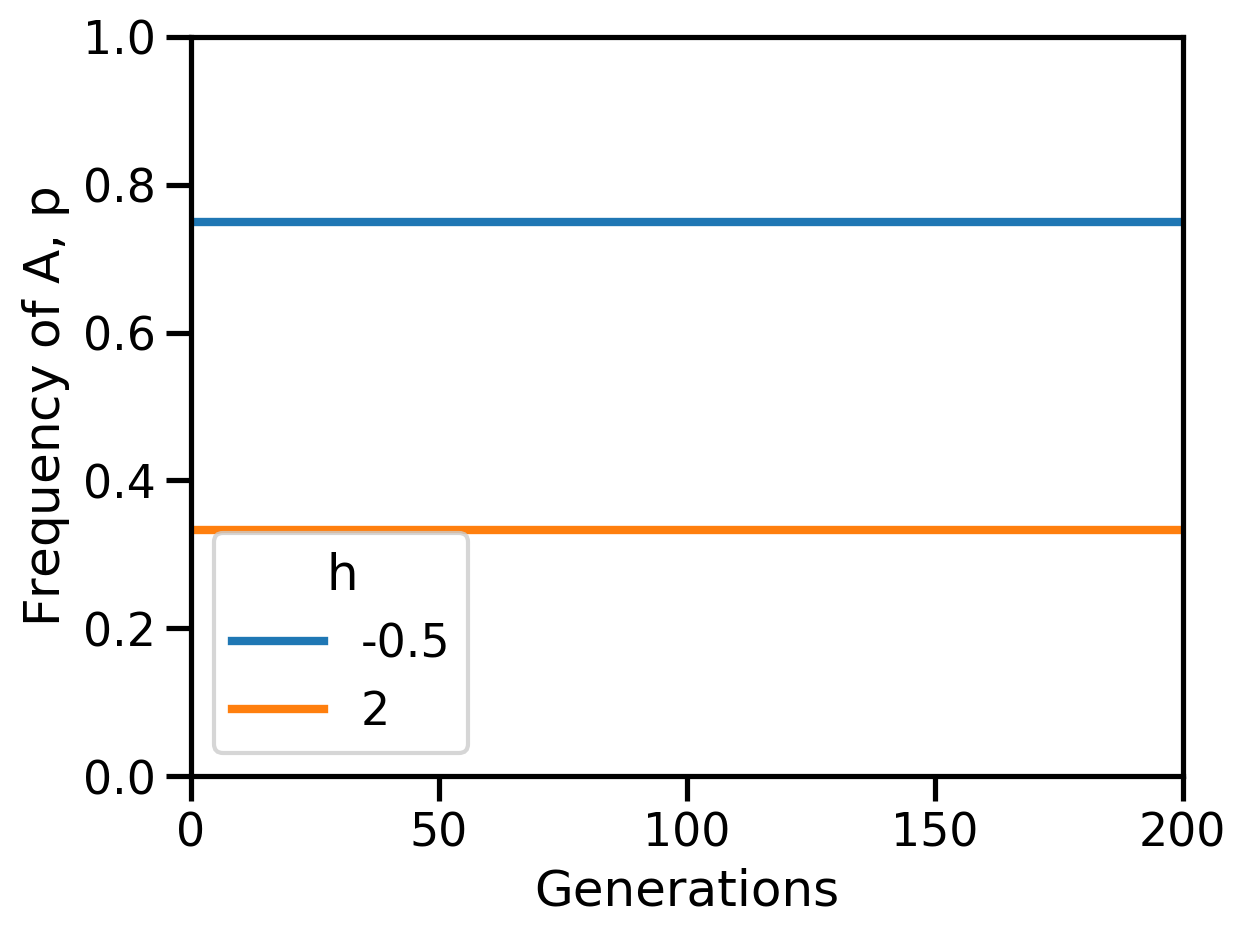

In [31]:
h = -1/2
p = diploid_selection((h-1)/(2*h-1), 0.1, h, 200)
plt.plot(p, lw=3, label=h)

h = 2
p = diploid_selection((h-1)/(2*h-1), 0.1, h, 200)
plt.plot(p, lw=3, label=h)

plt.xlabel('Generations')
plt.ylabel('Frequency of $A$, $p$')
plt.legend(title='$h$')
plt.ylim(0, 1)
plt.xlim(0, 200);

## Local stability

**Definition.** *Local stability* indicates that a system is stable over small short-lived disturbances.
Formally, an equilibrium $p^*$ is locally stable if there exists $\delta>0$ such that for any $p$ with $| p-p^* | < \delta$ we have
$$
|p' - p^*| < |p - p^*|
$$ 

We'll check for local stability of $p=0$ and $p=1$.

Denote the transformation $p'=F(p)=\frac{f(p)}{\bar{w}(p)}$ such that
$$
f(p)=p^2 + p(1-p) (1-hs), \\
\bar{w}(p)= p^2 +2pq (1-hs) + q^2 (1-s)
$$

This transformation can be approximated by a linear function (Taylor expansion) around a given point $p_0$ by
$$
p' = F(p) = F(p_0) + (p-p_0)F'(p) + o((p-p_0)^2)
$$

The derivative of the transformation $F(p)$ is
$$
F'(p) = \frac{f'(p) \bar{w}(p) - f(p) \bar{w}'(p)}{\bar{w}^2(p)}
$$
with
$f'(p) = 2p + (1-2p) (1-hs)$.
and we don't need to worry about $\bar{w}'(p)$$, as you will see next.


Set $p_0=0$ for fixation of $A_2$ and $p \approx 0$, that is, $o(p^2)=0$ (this is the small-o notation, which means that $p^2$ is very close to zero).
Then, with $F(0)=0$, $f'(0) = 2 \cdot 0 \cdot 1 + (1-2\cdot0) (1-hs)$, and $f(0)=0$ we get
$$
p' = F(p) = F(0) + p F'(0) + o(p^2) = \\
p\frac{f'(0) \bar{w}(0) - f(0) \bar{w}'(0)}{\bar{w}^2(0)} + o(p^2) = 
p\frac{1-hs}{1-s} + o(p^2)
$$

Therefore, disregarding terms of order $p^2$ (due to the small-o),
$$
\frac{p'}{p} = \frac{1-hs}{1-s}
$$

For stability of $p=0$ we require $\frac{p'}{p} < 1$.
Since $0 < s < 1$,
$$
\frac{1-hs}{1-s} < 1 \Rightarrow 
1-hs < 1-s \Rightarrow  \\
-hs < -s \Rightarrow 
h > 1
$$

Similarly, let $g(q) = q^2 (1-s) + q(1-q) (1-hs)$ with $g'(q) = 2q (1-s) + (1-2q) (1-hs)$ and set $q_0=0$ for fixation of $A_1$, so 
$$
q' = \frac{g(0) + (q - 0) g'(0) + o(q^2)}{\bar{w}(0)} \Rightarrow \\
q' = q \frac{1-hs}{1} + o(q^2)
$$

So, for $q \approx 0$ we have
$$
\frac{q'}{q} = \frac{1-hs}{1} = 1-hs
$$

Therefore, for stability of $q=0$ ($p=1$) we require 
$$
1-hs < 1 \Rightarrow \\
-hs < 0 \Rightarrow \\
h > 0
$$

**Result.**
Fixation of $A_1$ ($p=1$) is locally stable when $h>0$.

Fixation of $A_2$ ($p=0$) is locally stable when $h>1$.

**Definition.**
When both fixations are unstable, that is $h<0$, we have a *protected polymorphism*.

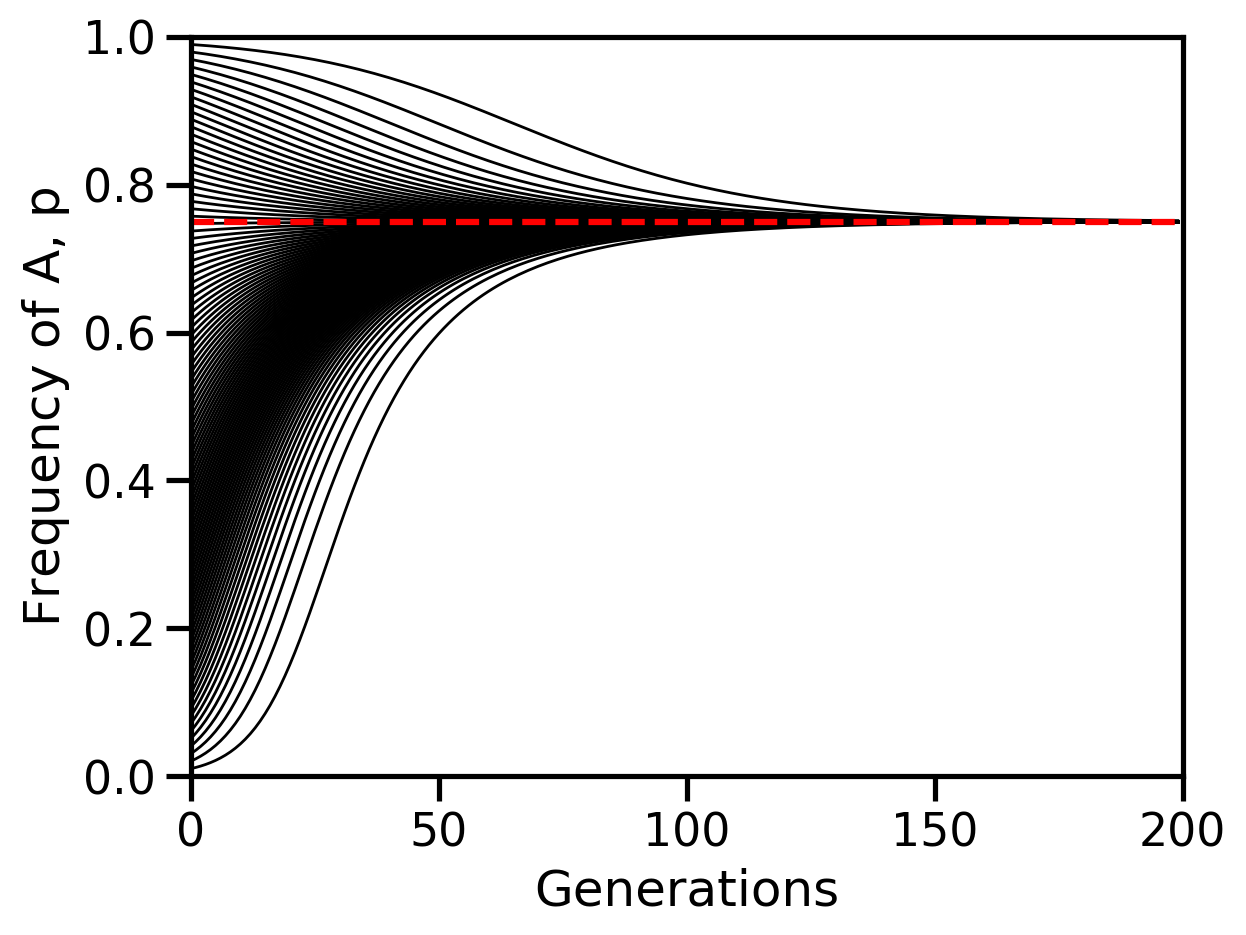

In [36]:
h = -1/2
for p0 in np.linspace(0, 1, 100):
    p = diploid_selection(p0, 0.1, h, 200)
    plt.plot(p, 'k', lw=1)

plt.axhline((h-1)/(2*h-1), ls='--', color='r')
plt.xlabel('Generations')
plt.ylabel('Frequency of $A$, $p$')
plt.ylim(0, 1)
plt.xlim(0, 200)
plt.title('h=-1/2');

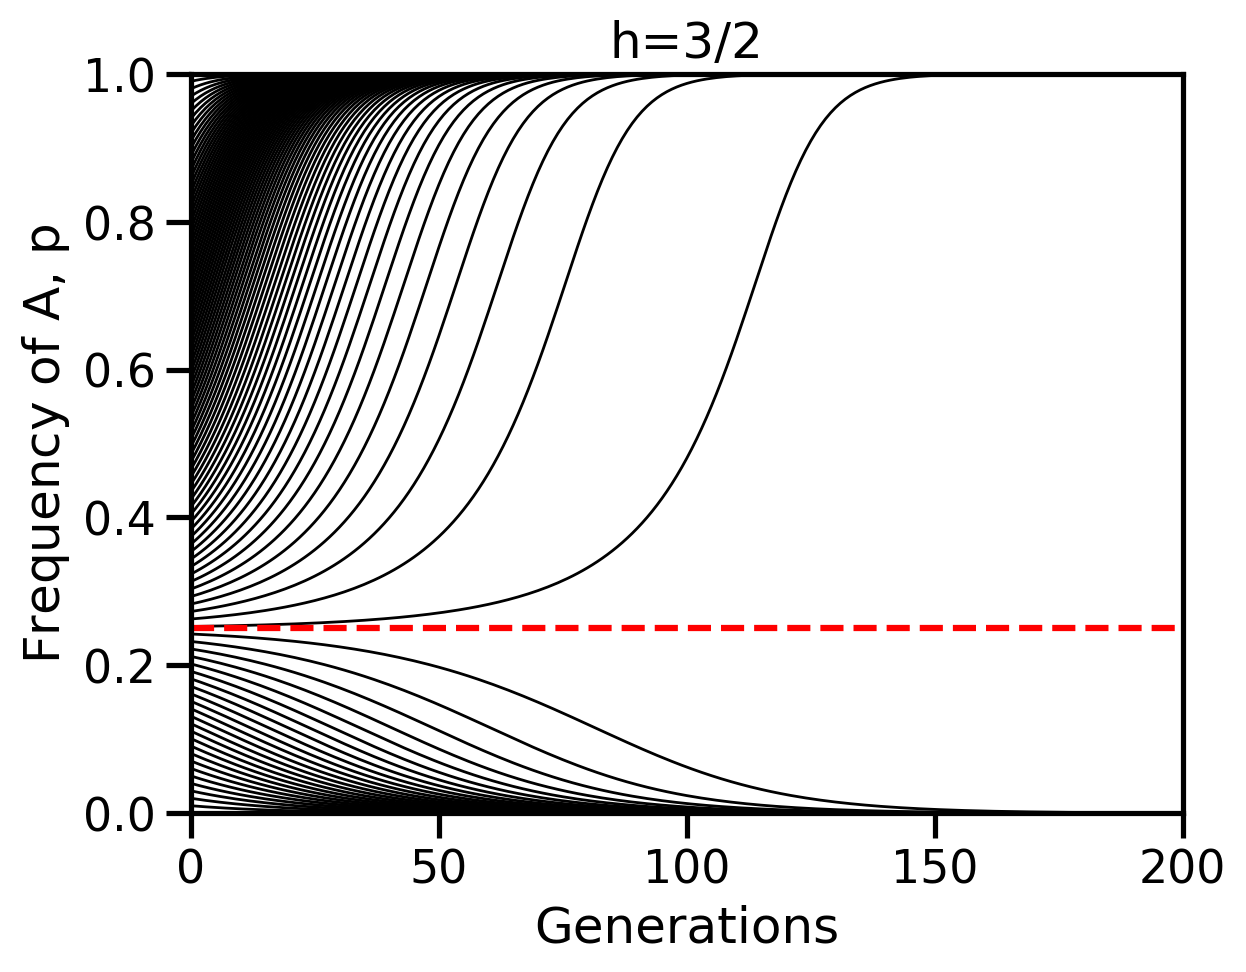

In [40]:
h = 3/2
for p0 in np.linspace(0, 1, 100):
    p = diploid_selection(p0, 0.1, h, 200)
    plt.plot(p, 'k', lw=1)

plt.axhline((h-1)/(2*h-1), ls='--', color='r')
plt.xlabel('Generations')
plt.ylabel('Frequency of $A$, $p$')
plt.ylim(0, 1)
plt.xlim(0, 200)
plt.title('h=3/2');

## Dominance

**Definition.**
*Overdominance* occurs when the $h<0$. Also called *heterozygote advantage*.

*Incomplete dominance* is when $0<h<1$. Also called *partial dominance*, *semi-dominance* or *intermediate inheritance*.

*Underdominance* is when $h>1$. Also called *heterozygote inferiority*, *heterozygote disadvantage*, and *disruptive selection*.

**Conclusion.**

With overdominance ($h<0$), fixations of $A_1$ and $A_2$ are unstable and there is a protected polymorphism $p^*=\frac{h-1}{2h-1}$.

With incomplete dominance ($0 \le h \le 1$), fixation of $A_1$ is a stable and fixation of $A_2$ is unstable.

With underdominance ($h>1$), fixations of $A_1$ and $A_2$ are stable, and $p^*$ separates the domains of attraction of the fixations.


### Example: Sickle cell and malaria

Sickle cell anaemia:

- Abnormality in the oxygen-carrying protein haemoglobin found in red blood cells
- Leads to rigid, sickle-like shape under certain circumstances
- A number of health problems may develop
- Causing allele in chromosome 11
- Recessive disease ($h=0$)

In 2015
- 4.4 million with sickle cell disease ($A_2 A_2$)
- 43 million with sickle cell trait ($A_1 A_2$)
- Mainly in Sub-Saharan Africa, India, Arabia.
- 114,800 deaths

Malaria:

- The malaria parasite attacks red blood cells
- When attacking sickle cells, they rupture prematurely
- Parasite cannot reproduce
- In areas where malaria is a problem $A_1 A_2$ have increased survival
- Overdominance $h<0$

### Distributions of sickle cell anaemia and of malaria

Sickle cell anaemia

![inline](../resources/Sickle_cell_distribution.jpg)

Malaria

![inline](../resources/Malaria_distribution.jpg)

# Discrete-time univariate deterministic model: selection and mutation

Assume the favorable allele $A_1$ mutates to $A_2$ with probability $u \ll 1$.
We neglect back mutation from $A_2$ to $A_1$ (becuase $A_2$ is deleterious so it will remain at a low frequency, and thus the product of its frequency and the mutation probability $u$ will be very low and negligble.

So, allele frequencies after selection and mutation:

$$
p' = (1-u)\frac{p^2 + p q (1-hs)}{p^2 + 2 p q (1-hs) + q^2 (1-s)}
$$

In [41]:
def diploid_selection_mutation(p0, s, h, u, tmax):
    p = [p0]

    for t in range(1, tmax):
        p_ = p[t-1]
        q_ = 1-p_
        wbar  = p_*p_ + 2*p_*q_*(1 - h*s) + q_*q_*(1-s) # mean fitness
        p.append( 
            (1-u) * (p_*p_ + p_*q_*(1-h*s)) / wbar
        )

    return p

Start with a simple model for a recessive gene, $h=0$.
Set $p'=p$, we have
$$
p = (1-u)\frac{p^2 + p q}{\bar{w}} \Rightarrow \\
p^2 + 2 p (1-p) + (1-p)^2 (1-s) - (1-u)(p + 1 - p) = 0 \Rightarrow \\
p^2 + 2 p - 2p^2 + (1-2p+p^2) (1-s) - 1 + u = 0 \Rightarrow \\
p^2(1-2+1-s) + p(2-2+2s) +1 - s - 1 +u = 0 \Rightarrow \\
-s p^2 + 2s p - s +u = 0 \Rightarrow \\
s p^2 - 2s p + s -u = 0 \Rightarrow \\
p^* = \frac{2s \pm \sqrt{4s^2 - 4 s (s-u)}}{2s} = 
1 \pm \frac{\sqrt{4su}}{2s} = 
1 \pm \sqrt{\frac{u}{s}}
$$

**Result.** 
The polymorphic equilibrium frequency of a completely recessive allele is $q^*=\sqrt{\frac{u}{s}}$.

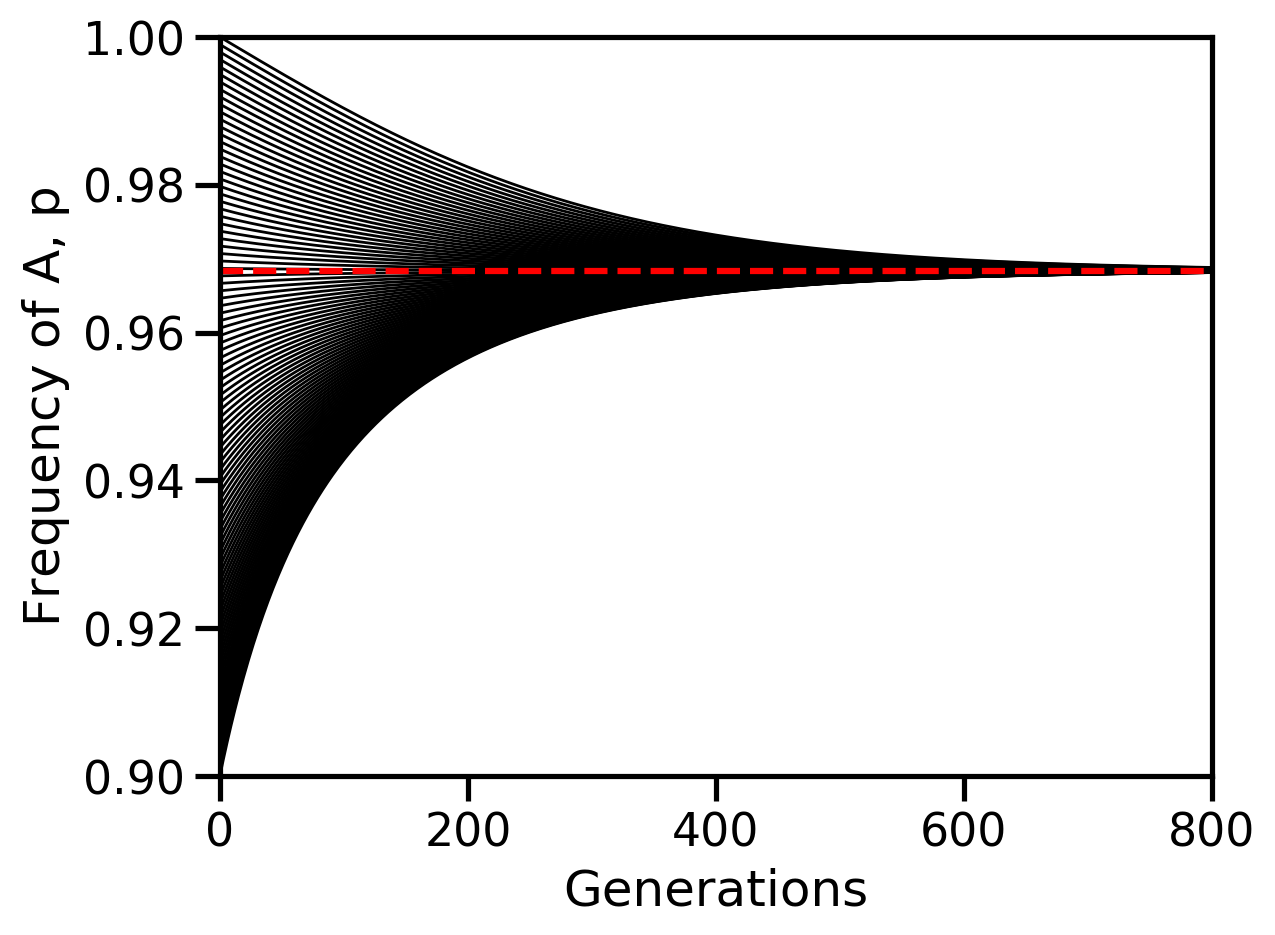

In [64]:
h = 0
u = 1e-4
s = 0.1
tmax = 800
for p0 in np.linspace(0.9, 1, 100):
    p = diploid_selection_mutation(p0, s, h, u, tmax)
    plt.plot(p, 'k', lw=1)

plt.axhline(1 - (u/s)**0.5, ls='--', color='r')
plt.xlabel('Generations')
plt.ylabel('Frequency of $A$, $p$')
plt.ylim(0.9, 1)
plt.xlim(0, tmax);

For parial dominance $h>0$, we first derive an expression for the change if the frequency of $A_1$ due to selection $\Delta_s p$.
$$
\bar{w} (p'-p) = p^2 + pq(1-hs) - p^3 -2p^2q(1-hs)-pq^2(1-s) = \\
p^2(1-p) + pq(1-hs) -2p^2q(1-hs)-pq^2(1-s) = \\
pq\big[p + 1 - hs -2p+2phs-q+qs \big] = \\
pq\big[p + 1 - hs -2p+2phs-1+p+s-sp \big] = \\
pq\big[-hs+2phs+s-sp\big] = \\
pqs\big[-h+ph+ph+1-p\big] = \\
pqs\big[-h(1-p)+ph+q\big] = \\
pqs\big[ph+q(1-h)\big] \Rightarrow \\
\Delta_s p = \frac{pqs(ph+q(1-h))}{\bar{w}}
$$

We now derive an expression for the change if the frequency of $A_1$ due to mutation $\Delta_u p$,
$$
p' = (1-u)p \Rightarrow \\
p'-p = -up = -u(1-q) = -u+uq
$$

and since $q \approx 0$ and $u \approx 0$, that is, both are very small, we disregard terms of the order of $qu$
$$
\Delta_u p = -u 
$$

To find a **mutation-selection balance** (this is a special name for the equilibrium between selection and mutation) we require $\Delta_s p + \Delta_u p = 0$
$$
\frac{pqs(ph+q(1-h))}{\bar{w}} - u = 0 \Rightarrow \\
pqs(ph+q(1-h)) = u \cdot \bar{w} \Rightarrow \\
pqs(ph+q(1-h)) = u \big[p^2 + 2pq(1-hs) +q^2(1-s) \big]
$$

Disregarding terms of the order of $q^2$ and $qu$,
$$
pqs(ph+q(1-h)) = u \big[p^2 + 2pq(1-hs) +q^2(1-s) \big] \Rightarrow \\
p^2qsh = u p^2 \Rightarrow \\
qsh = u
$$

**Result.**
The polymorphic equilibrium frequency of a partially recessive allele is $q^* \approx \frac{u}{sh}$.

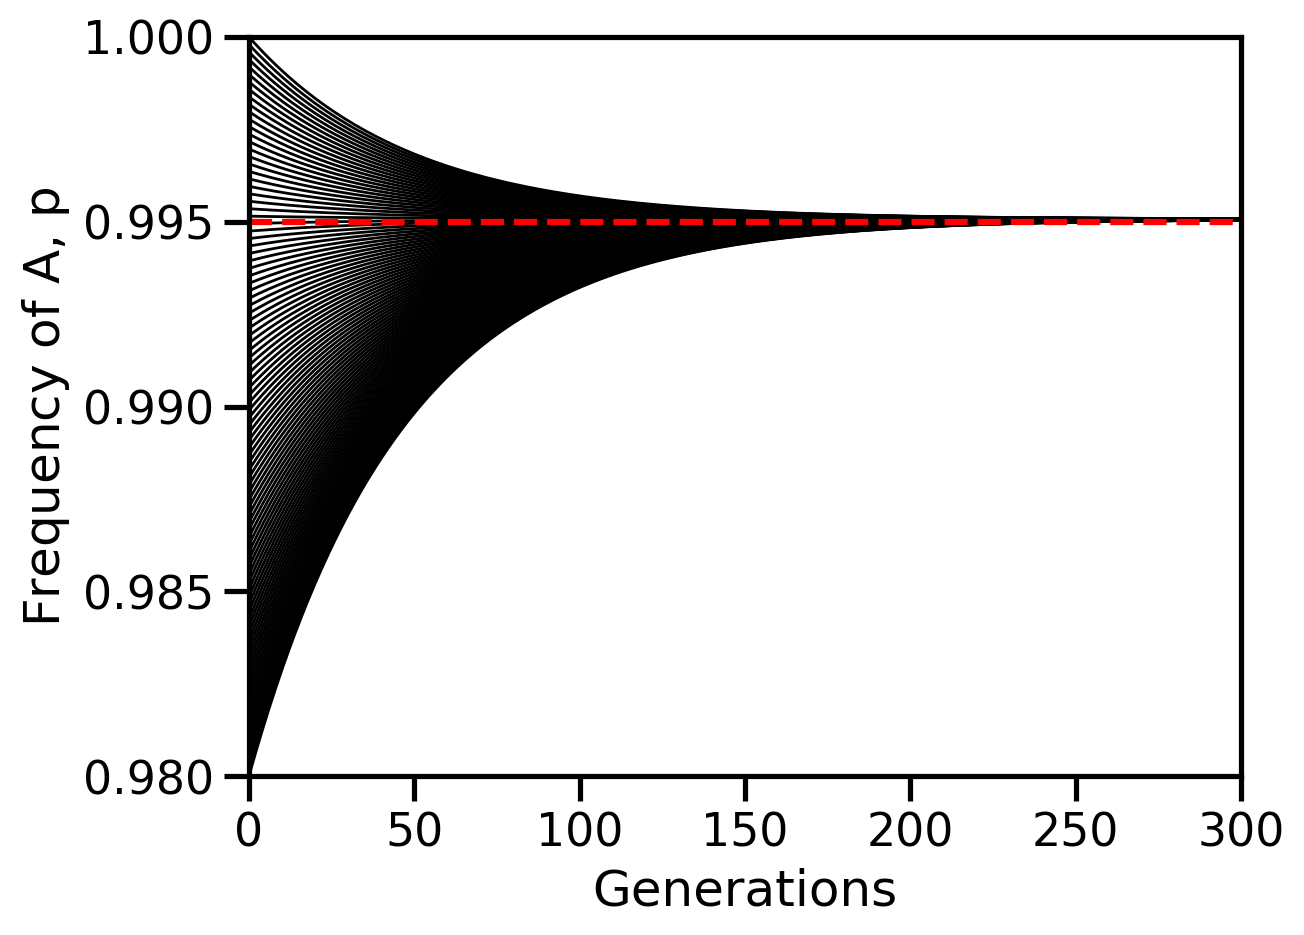

In [63]:
h = 0.2
u = 1e-4
s = 0.1
tmax = 300
for p0 in np.linspace(0.98, 1, 100):
    p = diploid_selection_mutation(p0, s, h, u, tmax)
    plt.plot(p, 'k', lw=1)

plt.axhline(1 - u/(s*h), ls='--', color='r')
plt.xlabel('Generations')
plt.ylabel('Frequency of $A$, $p$')
plt.ylim(0.98, 1)
plt.xlim(0, tmax);

# Stochastic model: large population

We mentioned before that the assumption of a _very large population_ may break when either the population is small or when the number of individuals of a certain type is small.

We'll start with the later case.
In this case, the population is very large but $A$ is initially very rare, so the dynamics of $A$ while rare are stochastic.

A common model for such dynamics is a **branching process**.

For simplicity, we assume that the number of offspring per individual is Poisson distributed, with mean $1$ for type $B$ and $1+s$ for type $A$.

So the probability that an $A$ individual leaves $k$ offspring is

$$
P(k) = e^{-(1+s)}\frac{(1+s)^k}{k!}
$$

From Otto and Day 2007 (ch. 14.5):

> The key insight made by Haldane (1927) was that the probability that a type ultimately leaves no descendants must equal the probability that each offspring produced by this type leaves no descendants.

So we can write

$$
p_{loss} = \sum_{k=0}^{\infty}{p_{loss}^k P(k)} = \\
e^{-(1+s)} \sum_{k=0}^{\infty}{\frac{\big((1+s)p_{loss}\big)^k}{k!}} = \\
e^{-(1+s)} e^{p_{loss}(1+s)}
$$

where the last transition is due to the Taylor expansion on the exponential function.

So we get 

$$
p_{loss} = e^{-(1-p_{loss})(1+s)}
$$

The solution to these relationship cannot be expressed using elementary functions, and in fact, the solution is called a [Lambert W function](https://en.wikipedia.org/wiki/Lambert_W_function). A good introduction for the application of Lambert W in population biology can be found in [Lehtonen 2016](https://doi.org/10.1111/2041-210X.12568).

We can find the specific Lambert W function which solves this relationship using with [SymPy](http://sympy.org), a Python framework for symbolic mathematics:

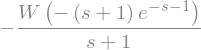

In [7]:
ploss, s = sympy.symbols('p_{loss} s')
eq = ploss - sympy.exp(-(1 - ploss) * (1 + s))
sol = sympy.solve(eq, ploss)[0]

sol

Let's plot the result:

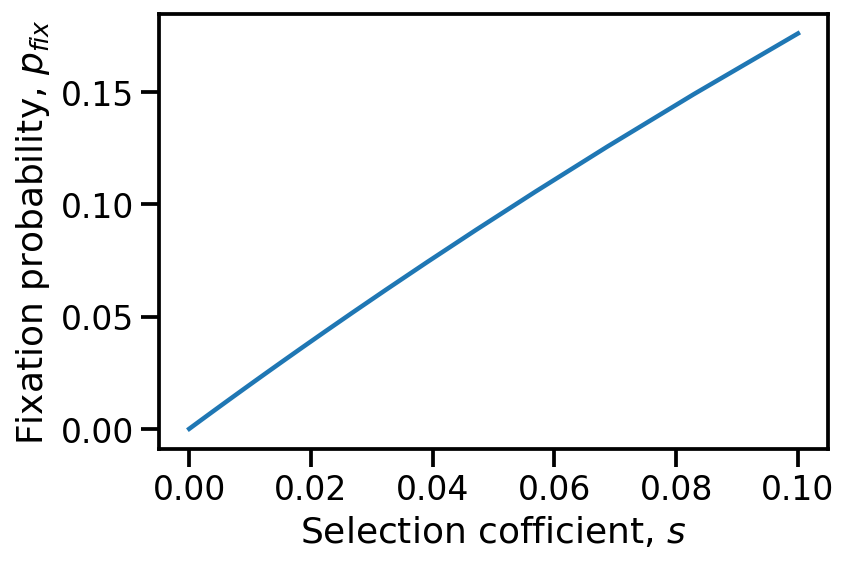

In [8]:
s = np.logspace(-5, -1)
pfix = [1 - sol.evalf(subs=dict(s=s_)) for s_ in s]

plt.plot(s, pfix)
plt.xlabel('Selection cofficient, $s$')
plt.ylabel('Fixation probability, $p_{fix}$');

We can rewrite the formula in terms of $p_{fix}=1-p_{loss}$:

$$
p_{fix} = 1-e^{-(1+s)p_{fix}} 
$$

If we assume that $s$ and $p_{fix}$ are both *small* (i.e. porportional to some small $\epsilon$), we can use the Taylor expansion for the exponential function (again) to get, up to term of order $o(\epsilon^3)$,

$$
p_{fix} \approx (1+s)p_{fix} - \frac{1}{2}\big((1+s)p_{fix}\big)^2
$$

To solve this we do some algebra and use the quadratic formula

$$
p_{fix} - (1+s)p_{fix} + \frac{1}{2}\big((1+s)p_{fix}\big)^2 = 0 \Rightarrow \\
\frac{1}{2}(1+s)^2 p_{fix}^2 -s p_{fix} = 0 \Rightarrow \\
p_{fix} = \frac{s \pm s}{(1+s)^2}
$$

So we get that $p_{fix} \approx s\frac{s}{1+s}$, and since $s$ is small, we have $p_{fix} \approx 2s$.

Let's compare it to the full result (the Lambert W function).

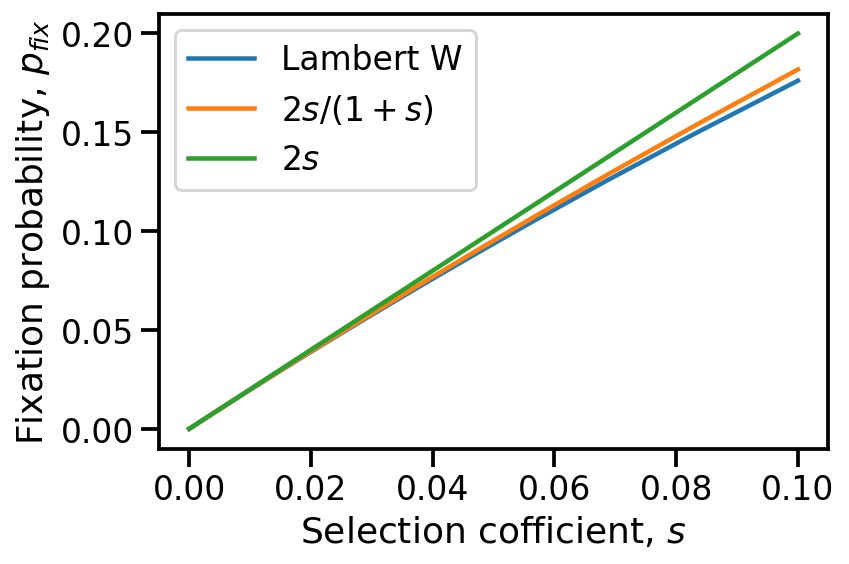

In [9]:
plt.plot(s, pfix, label='Lambert W')
plt.plot(s, 2*s/(1+s), label='$2s/(1+s)$')
plt.plot(s, 2*s, label='$2s$')
plt.xlabel('Selection cofficient, $s$')
plt.ylabel('Fixation probability, $p_{fix}$');
plt.legend();

So we can use one of the two approximations, depending on the value $s$.

# Stochastic model: small population

In a small population, random effects can affect the dynamics even when both types are common.

We will use the **Wright-Fisher model**:
at each generation the number of offspring of type $A$, which we mark $n$ , is binomially distributed $Bin(N, p)$, where $p$ is the frequency of $A$ parents.

![Sewall Wright](https://upload.wikimedia.org/wikipedia/en/8/8d/Sewall_Wright-en.jpg)

**[Sewall Wright](https://en.wikipedia.org/wiki/Sewall_Wright), 1889 - 1988**

![R.A. Fisher](https://upload.wikimedia.org/wikipedia/commons/2/21/RonaldFisher1912.jpg)

**[R.A. Fisher](https://en.wikipedia.org/wiki/Ronald_Fisher), 1890 - 1972**

## Conceptual model

Consider a population of $N$ individuals.
$p$ of the individuals are of type $A$, and $1-p$ are of type $B$.
In each reproductive cycle (generation), $A$ and $B$ individuals reproduce at a rate $1+s$ and $1$, where $s>0$ is the selection coefficient of $A$.

This is similar to an urn with $N$ balls, of which $p$ are blue and $1-p$ are red.
At each generation we fill a new urn with balls:
1. we draw a ball from the previous urn, where the odds to draw blue vs red balls is $1+s$.
1. we put a new ball in the new urn with the color of the drawn ball.
1. repeat until the new urn has $N$ balls.

In [2]:
HTML("""<script async class="speakerdeck-embed" data-id="a82ed8531523453d86f7fc09c857749e" data-ratio="1.77777777777778" src="//speakerdeck.com/assets/embed.js"></script>""")

## Pure Python implementation

First we implement the model using a pure Python function.

Of course, everytime we run the simulation we will get a different result (yay randomness).

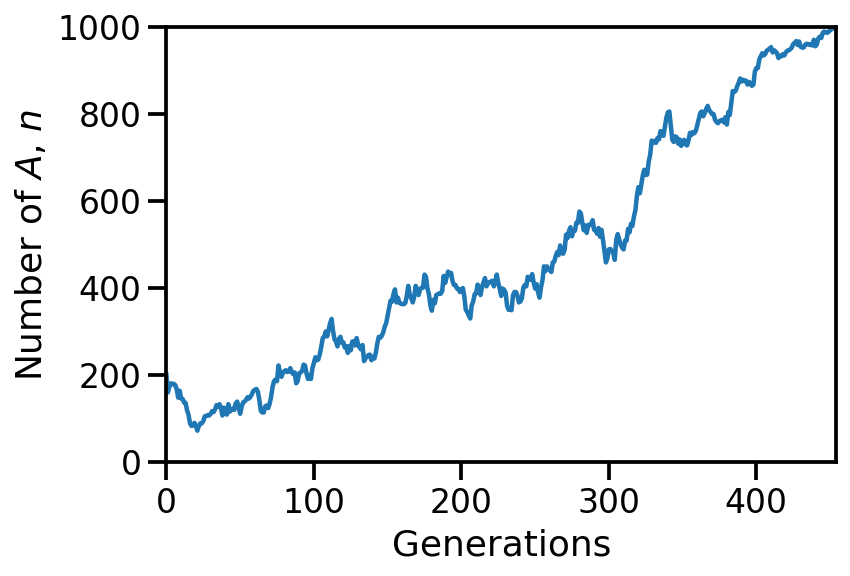

In [10]:
def simulation_py(n0, N, s):
    n = [n0]

    while 0 < n[-1] < N:
        p = n[-1] * (1 + s) / (N + n[-1] * s)
        sample = ( # generator expression
            1 
            for _ in range(N) 
            if random.random() < p
        )
        n.append(sum(sample))

    return n

n0 = 200 
N = 1000
s = 0.001

n = simulation_py(n0, N, s)

plt.plot(n)
plt.xlabel('Generations')
plt.ylabel('Number of $A$, $n$')
plt.ylim(0, N)
plt.xlim(0, len(n));

In [6]:
%timeit simulation_py(n0=200, N=1000, s=0.1)
%timeit simulation_py(n0=2000, N=10000, s=0.1)

11.1 ms ± 767 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
153 ms ± 9.53 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


This becomes slow when $N$ is large, but we don't really care too much because when $N$ is large we can use the deterministic model.

But still, we can do faster than that using NumPy.

## NumPy implementation

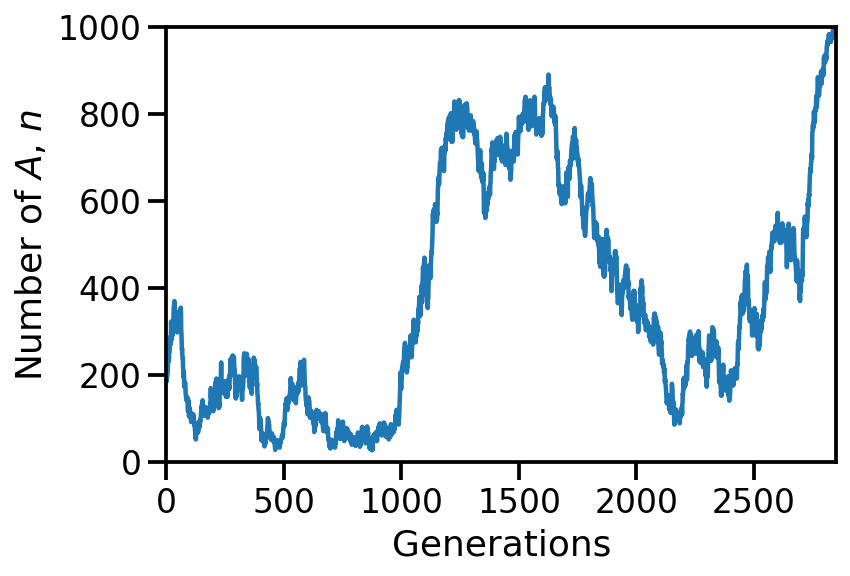

In [11]:
def simulation_np(n0, N, s, buflen=1000):
    n = np.empty(buflen)
    n[0] = n0
    t = 0
    while 0 < n[t] < N:        
        p = n[t] * (1 + s) / (N + n[t] * s)
        t += 1
        if t == len(n):
            n = np.append(n, np.empty(buflen))
        n[t] = np.random.binomial(N, p)

    return n[:t+1].copy()


n0 = 200 
N = 1000
s = 0.001

n = simulation_np(n0, N, s)

plt.plot(n)
plt.xlabel('Generations')
plt.ylabel('Number of $A$, $n$')
plt.ylim(0, N)
plt.xlim(0, len(n));

In [8]:
%timeit simulation_np(n0=200, N=1000, s=0.1)
%timeit simulation_np(n0=2000, N=10000, s=0.1)

288 µs ± 42.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
440 µs ± 36 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


This is much faster than the pure Python implementation, and the differences between population sizes is smaller.

Can we do even faster?

## Multiple simulations

Since the dynamics are random, we will want to run many replications of the simulation and collect some statistics.

### Pure Python

In [12]:
def simulations_py(n0, N, s, repetitions=10):
    return [
        simulation_py(n0, N, s) 
        for _ in range(repetitions)
    ]

n = simulations_py(n0, N, s, 100)

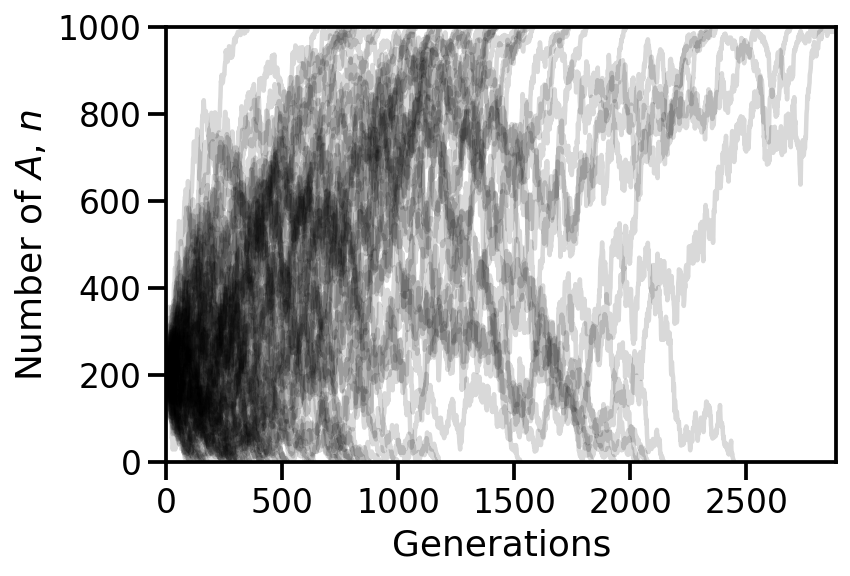

In [13]:
for n_ in n:
    plt.plot(n_, 'k', alpha=0.15)
plt.xlabel('Generations')
plt.ylabel('Number of $A$, $n$')
plt.ylim(0, N)
plt.xlim(0, max(len(n_) for n_ in n));

In [26]:
%timeit simulations_py(200, 1000, 0.1, 100)
%timeit simulations_py(2000, 10000, 0.1, 100)

1.05 s ± 19.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
15.7 s ± 637 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### NumPy

We can do fater with NumPy.

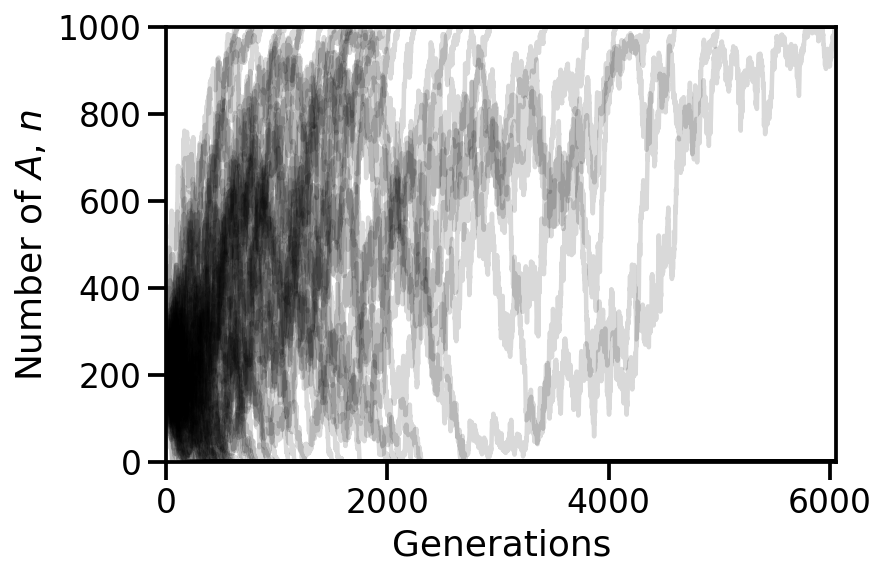

In [14]:
def simulations_np(n0, N, s, repetitions=10, buflen=1000):
    n = np.zeros((buflen, repetitions))
    n[0,:] = n0
    t = 0
    update = (n[t] > 0) & (n[t] < N)
    while update.any():
        t += 1
        p = n[t-1] * (1 + s) / (N + n[t-1] * s)
        if t == n.shape[0]:
            n = np.concatenate((n, np.zeros((buflen, repetitions))))
        n[t, update] = np.random.binomial(N, p[update])
        n[t, ~update] = n[t-1, ~update]
        update = (n[t] > 0) & (n[t] < N)

    return n[:t].copy()

n = simulations_np(n0, N, s, 100)
plt.plot(n, 'k', alpha=0.15)
plt.xlabel('Generations')
plt.ylabel('Number of $A$, $n$')
plt.ylim(0, N)
plt.xlim(0, n.shape[0]);

This is a more sophisticated way to visualize the same result.

The x-axis is still time; the y-axis represents the repitions (or population), and the color denotes the frequency of type $A$, from dark for zero to bright for 1.

The repetitions are ordered by the average frequency of type $A$ over the entire simulation duration, so that simulations with quick fixation of $A$ are at the top, simulations with quick extinction of $A$ are at the bottom, and simulations that took a long time to end are at the middle.

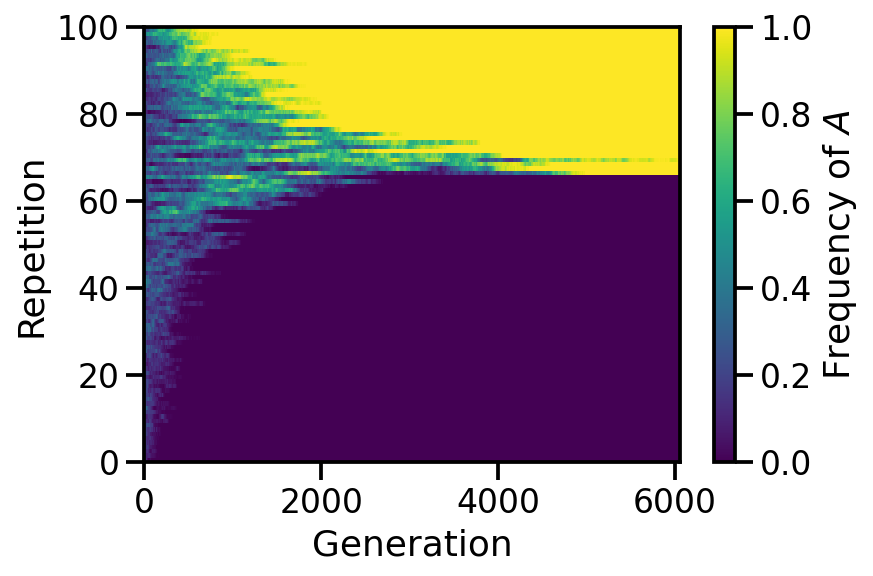

In [15]:
idx = n.mean(axis=0).argsort()
plt.pcolormesh(n[:, idx].T / N)
plt.colorbar(label='Frequency of $A$')
plt.xlabel('Generation')
plt.ylabel('Repetition');

In [13]:
%timeit simulations_np(n0=200, N=1000, s=0.1, repetitions=1000)
%timeit simulations_np(n0=2000, N=10000, s=0.1, repetitions=1000)

18.9 ms ± 802 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
21.1 ms ± 679 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


We can see that the NumPy implementation is much faster.

## Fixation probability (stochastic model)

If we want to estimate the fixation probability, we don't actually need to save the entire `n` array.

In [16]:
def fix_prob(n0, N, s, repetitions=10):
    N = int(N)
    n = np.repeat(n0, repetitions)
    n[:] = n0 # broadcasting
    update = (n > 0) & (n < N)
    while update.any():
        p = n * (1 + s) / (N + n * s)
        n[update] = np.random.binomial(N, p[update])
        update = (n > 0) & (n < N)

    return (n == N).mean()

fix_prob(1, 100, 0.1, 100000)

This saves both memory and CPU.

In [45]:
%timeit n = simulations_np(1, 100, 0.1, 100000); (n[-1,:]==N).mean()
%timeit fix_prob(1, 100, 0.1, 100000)

803 ms ± 52.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
416 ms ± 14.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Now let's plot the fixation probability for different population sizes; we expect it to converge to the deterministic result $2s$ for large populations.

In [17]:
Ns = np.logspace(1, 6, 100, dtype=int)
s = 0.001
n0 = 1

pfix = [fix_prob(n0, N, s, 1000) for N in Ns]

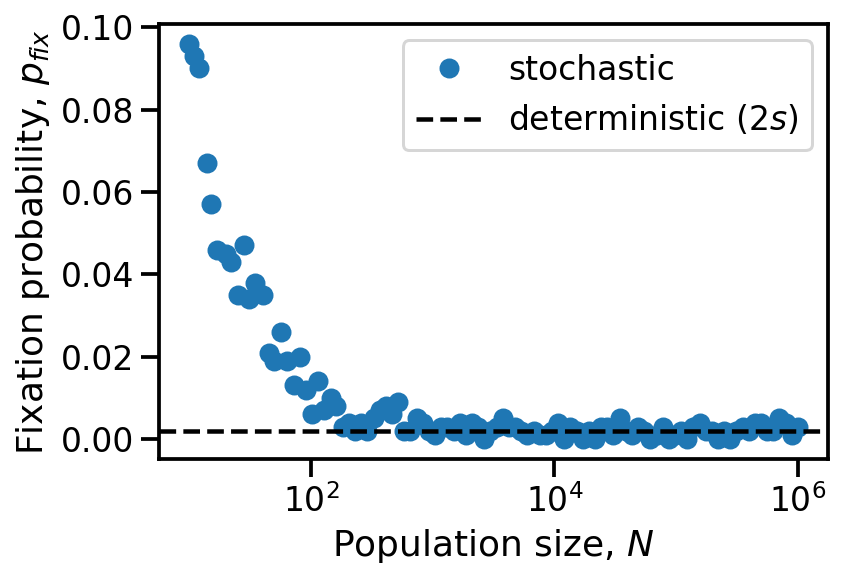

In [18]:
plt.plot(Ns, pfix, 'o', label='stochastic')
plt.axhline(2*s, ls='--', color='k', label='deterministic $(2s)$')

plt.xlabel('Population size, $N$')
plt.xscale('log')
plt.ylabel('Fixation probability, $p_{fix}$')
plt.legend();

## Diffusion equation approximation for fixation probability

There is a rather good approximation even for small population sizes.
Using a diffusion equation approximation, [Kimura (1962)](http://www.ncbi.nlm.nih.gov/pmc/articles/PMC1210364/) reached his famous equation:

$$
\frac{1 - e^{-2 n_0 s}}{1 - e^{-2 N s}}
$$

For large $N$, the denominator is roughly 1, and if $s$ is small than we can approximate this by $2s$. 

For a modern derivation see Durrett's [Probability Models for DNA Sequence Evolution](https://services.math.duke.edu/~rtd/Gbook/Gbook.html), ch. 7 (free online).

[![Kimura](https://upload.wikimedia.org/wikipedia/en/4/48/Motoo_Kimura.jpg)](https://en.wikipedia.org/wiki/Motoo_Kimura)

**Motoo Kimura, 1924 - 1994**

In [19]:
def fix_kimura(n0, N, s):
    return np.expm1(-2 * n0 * s) / np.expm1(-2 * N * s)

Note the use of `expm1(x)` which is more precise than `exp(1-x)` for small `x` values.

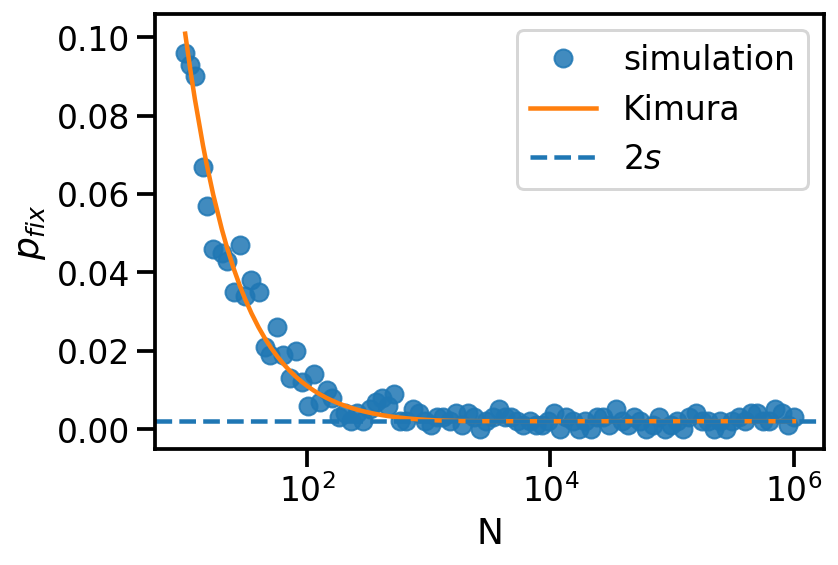

In [20]:
plt.plot(Ns, pfix, 'o', alpha=0.85, label='simulation')
plt.plot(Ns, fix_kimura(n0, Ns, s), '-', label='Kimura')
plt.axhline(2*s/(1+s), ls='--', label='$2s$')

plt.xlabel('N')
plt.xscale('log')
plt.ylabel('$p_{fix}$')
plt.legend();

This approximation does the job very well.

Behold the power of NumPy's `ufunc`:

In [58]:
Ns_ = np.logspace(1, 6, 5000, dtype=np.int64)
%timeit [fix_kimura(n0, N, s) for N in Ns_]
%timeit fix_kimura(n0, Ns_, s)

26.1 ms ± 635 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
53.7 µs ± 887 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


## Numba implementation

[Numba](http://numba.pydata.org/) is a JIT compiler for Python and NumPy built over LLVM

In [21]:
import numba

fix_kimura_nm = numba.jit(fix_kimura)
fix_kimura_nm(n0, N, s); # burn-in for the jit to work

In [61]:
Ns = np.logspace(1, 6, 100, dtype=float)
%timeit fix_kimura(n0, Ns, s)
%timeit fix_kimura_nm(n0, Ns, s)

7.2 µs ± 204 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
1.54 µs ± 50.8 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [62]:
Ns = np.logspace(1, 6, 10000, dtype=float)
%timeit fix_kimura(n0, Ns, s)
%timeit fix_kimura_nm(n0, Ns, s)

84.9 µs ± 7.52 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
77.1 µs ± 3.74 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


## Fixation time (stochastic)

Now we will focus on the *time* it takes for the fixation of one of the type to occur.

In [22]:
def fix_time(n0, N, s, repetitions=10):
    N = int(N)
    n = np.repeat(n0, repetitions)
    T = np.repeat(np.inf, repetitions)
    
    t = 0
    n[:] = n0
    update = (n > 0) & (n < N)
    while update.any():        
        p = n * (1 + s) / (N + n * s)
        n[update] = np.random.binomial(N, p[update])
        update = (n > 0) & (n < N)
        t += 1
        T[~update] = np.minimum(T[~update], t)
    return n == N, T

In [23]:
n0 = 10
N = 1000
s = 0.01
fixations, times = fix_time(n0, N, s, 100000)

We'll plot the distribution of waiting time for fixation of $A$ and for extinction of $A$.

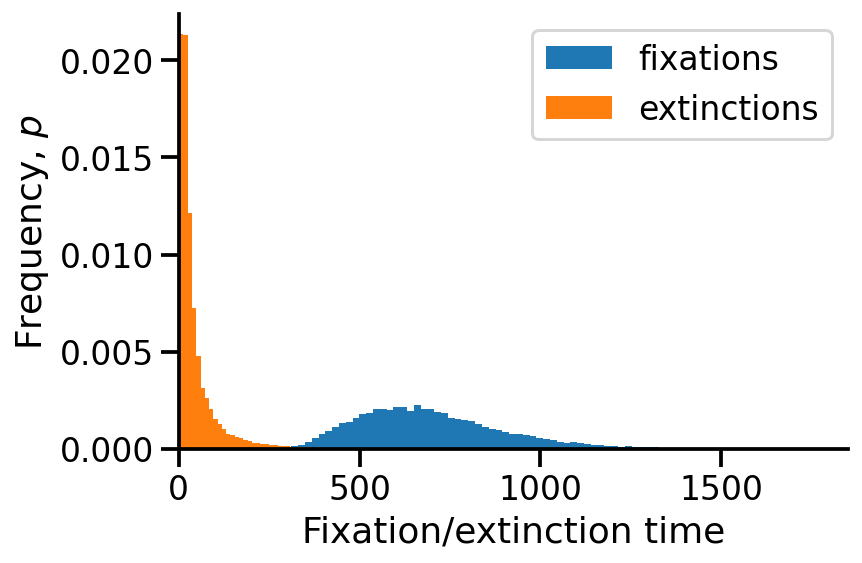

In [31]:
fig, ax = plt.subplots()

ax.hist(times[fixations], bins=100, density=True, label='fixations')
ax.hist(times[~fixations], bins=100, density=True, label='extinctions')

ax.set(
    xlim=(0, -4 * np.log(n0/N) / np.log(1+s)),
    xlabel='Fixation/extinction time',
    ylabel='Frequency, $p$'
)
ax.legend()
sns.despine()

### Deterrministic approximation

We can now compare the expected fixation time to an approximation derived from the deterministic model above.

In [32]:
def mean_std_fix_time(fixations, times):
    fix_times = times[fixations]
    return fix_times.mean(), fix_times.std(ddof=1)

n0 = 1
Ns = np.logspace(1, 8, 50, dtype=int)
s = 0.01
fix_times = np.array([
    mean_std_fix_time(*fix_time(n0, N, s, 10000)) 
    for N in Ns
])

The deterministic approximation is (see above)
$$
t = -2 \frac{log(p_0)}{log{(1+s)}}
$$

In [33]:
def T_haldane(n0, Ns, s):
    return -2 * np.log(n0/Ns) / np.log(1+s)

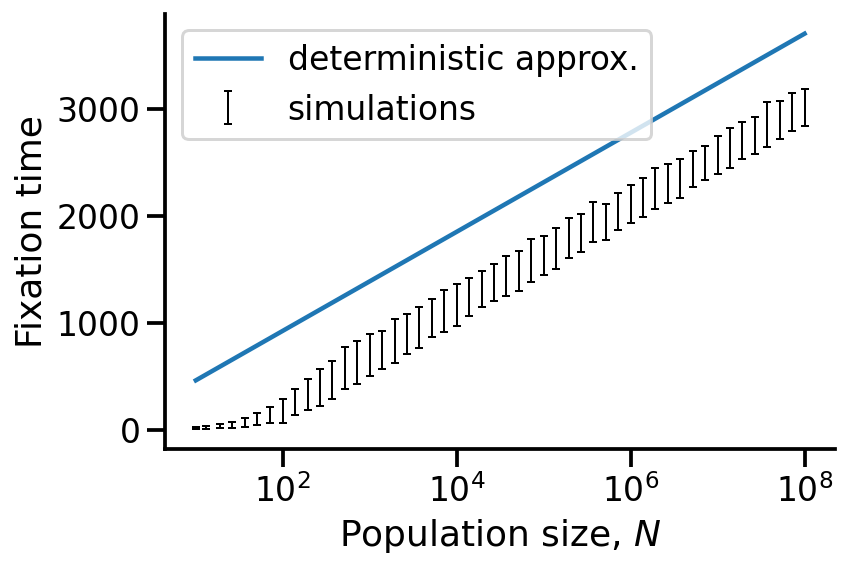

In [34]:
plt.errorbar(Ns, fix_times[:,0], yerr=fix_times[:,1], 
             capsize=2, capthick=1, lw=0, label='simulations',
             ecolor='k', elinewidth=1)
plt.plot(Ns, T_haldane(n0, Ns, s), label='deterministic approx.')
plt.xscale('log')
plt.xlabel('Population size, $N$')
plt.ylabel('Fixation time')
plt.legend()
sns.despine()

We can see that the deterministic approximation constantly over estimates the fixation time.

Can we have a better approximation?

### Diffusion equation approximation for fixation time

Another approximation of the fixation time is based on a diffusion equation and is given in [Kimura and Ohta 1969](http://www.pubmedcentral.nih.gov/articlerender.fcgi?artid=1212239) (eq. 17). It assumes a population size of $2N$ gametes and selection advantage of $s/2$ rather then $N$ and $s$, therefore I'm changing $s=2s$ and $N=N/2$. Also, it has the initial frequency as $x$, so we define $x=n_0/N$.

$$
I_1(x) = \frac{1 - e^{-2 n_0 s} - e^{-2Ns(1-x)} + e^{-2Ns}}{x(1-x)} \\
I_2(x) = \frac{(e^{2Nsx} - 1) (1 - e^{-2Ns(1-x)})}{x(1-x)} \\
J_1 = \frac{1}{s(1-e^{-2Ns})} \int_{x}^{1}{I_1(y) dy} \\
J_2 = \frac{1}{s(1-e^{-2Ns})} \int_{0}^{x}{I_2(y) dy} \\
u = \frac{1 - e^{-2Nsx}}{1 - e^{-2Ns}} \\
T_{fix} = J1 + \frac{1-u}{u} J_2
$$

For a modern derivation see Durrett's [Probability Models for DNA Sequence Evolution](https://services.math.duke.edu/~rtd/Gbook/Gbook.html), ch. 7 (free online).

Here we need to integrate some functions, we'll do this using `scipy.integrate.quad`. 

`functools.partial` reduces the number of arguments a function expects, effectively freezing some of them - mathematically, it creates a projection.

`np.vectorize` is a decorator that converts a scalar function to an array function, giving it the `ufunc` super powers.

In [35]:
from scipy.integrate import quad 
from functools import partial

def integral(f, N, s, a, b):
    f = partial(f, N, s)    
    return quad(f, a, b)[0]

In [36]:
def I1(N, s, x):
    if x == 1:
        return 0
    return (1 - np.exp(-2*N*s*x) - np.exp(-2 * N * s * (1 - x)) + np.exp(-2 * N *s)) / (x*(1-x))

def I2(N, s, x):
    if x == 0:
        return 0
    return -np.expm1(2 * N * s * x) * np.expm1(-2 * N * s * x) / (x * (1 - x))

@np.vectorize
def T_kimura(n0, N, s):
    x = n0 / N
    J1 = -1.0 / (s * np.expm1(-2 * N * s)) * integral(I1, N, s, x, 1)
    u = np.expm1(-2 * N * s * x) / np.expm1(-2 * N * s)
    J2 = -1.0 / (s * np.expm1(-2 * N *s)) * integral(I2, N, s, 0, x)
    return J1 + ((1 - u) / u) * J2

assert 254 < T_kimura(1, 1e6, 0.1) < 255

Behold the power of `np.vectorize`.

In [65]:
Ns = np.logspace(1, 6, 100)
%timeit np.array([T_kimura(n0, N, s) for N in Ns])
%timeit T_kimura(n0, Ns, s)

337 ms ± 30.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
116 ms ± 4.55 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Let's compare the simulation results with the two approximations:

In [37]:
n0 = 1
Ns = np.logspace(1, 8, 50, dtype=int)
s = 0.01

fix_time_kimura = T_kimura(n0, Ns, s)
fix_time_haldane = T_haldane(n0, Ns, s)

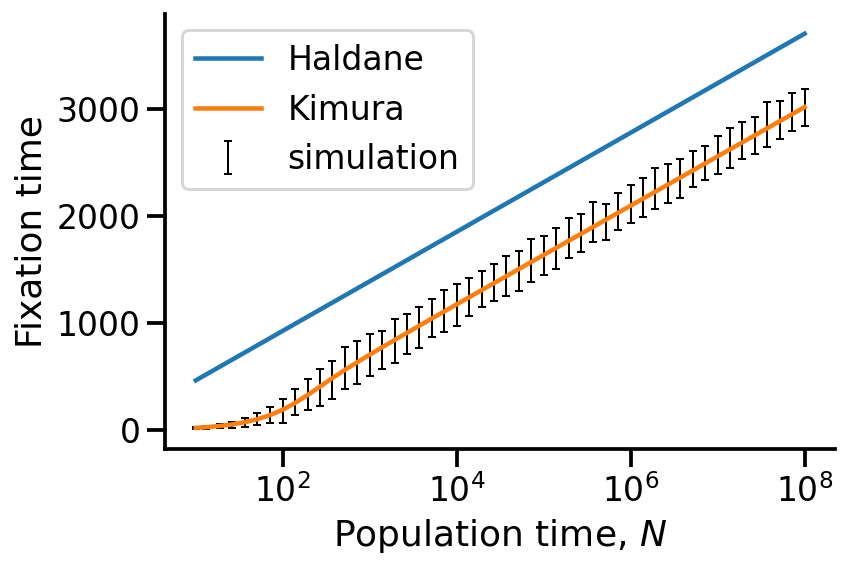

In [38]:
plt.errorbar(Ns, fix_times[:,0], yerr=fix_times[:,1], 
             capsize=2, capthick=1, lw=0, label='simulation',
             ecolor='k', elinewidth=1)
plt.plot(Ns, fix_time_haldane, label='Haldane')
plt.plot(Ns, fix_time_kimura, label='Kimura')

plt.xscale('log')
plt.xlabel('Population time, $N$')
plt.ylabel('Fixation time')
plt.legend()
sns.despine()

Kimura's diffusion approximation is fantastic.

# Colophon
This notebook was written by [Yoav Ram](http://www.yoavram.com) and is part of the [Models in Population Biology](http://modelspopbiol.yoavram.com) course at Tel Aviv University.

This work is licensed under a CC BY-NC-SA 4.0 International License.